# Semantic Segmentation, Metric Learning and GardCam


Имя, Фамилия: Лидия Карпович



---


In [1]:
!pip install --quiet opencv-python segmentation-models-pytorch pytorch-lightning torchmetrics grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.7/931.7 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 

In [ ]:
!pip install faiss-cpu
!pip install pytorch_lightning
!pip install segmentation_models_pytorch
!pip install pytorch_metric_learning

In [ ]:
!pip install lightning

In [5]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import faiss
from PIL import Image
import requests
import scipy.io

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, models
from torchvision.datasets import VOCSegmentation
import lightning.pytorch as pl

from torchvision.models import resnet50

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from torchmetrics import Accuracy

import segmentation_models_pytorch as smp
from pytorch_metric_learning import losses
from pytorch_grad_cam import GradCAM

import seaborn as sn

%matplotlib inline

## 0. PyTorch Lightning: мини-курс

[PyTorch Lightning](https://pytorch-lighting.readthedocs.io/en/stable/) — это фреймворк, упрощающий разработку моделей глубокого обучения на PyTorch. Он не заменяет PyTorch, а скорее является его надстройкой. Lightning разделяет логику модели (архитектура) и инженерную логику (обучение, валидация, логирование), делая код чище, воспроизводимее и масштабируемее. Он также автоматизирует многие рутинные задачи, позволяя сосредоточиться на исследовании, а не на написании шаблонного кода. Он упрощает масштабирование на GPU/TPU и обеспечивает лучшую организацию проекта. В итоге, Lightning ускоряет разработку и делает код более понятным и поддерживаемым.

**Потратьте немного времени на изучение Lightning, и вы не пожалеете!**




Далее мы рассмотрим основы Lightning, подготовив модели для обучения на нашем любимом MNIST. Код взят [отсюда](https://pytorch-lighting.readthedocs.io/en/latest/notebooks/lightning_examples/mnist-hello-world.html)

In [ ]:
PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64

### 0.1 Простейший пример обучения

Вот самый минимальный пример, содержащий только цикл обучения (без валидации и тестирования)

Обратите внимание: `LightningModule` — это PyTorch `nn.Module`, просто с несколькими дополнительными полезными функциями.

In [ ]:
class MNISTModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(28 * 28, 10)

    def forward(self, x):
        return torch.relu(self.l1(x.view(x.size(0), -1)))

    def training_step(self, batch, batch_nb):
        x, y = batch
        loss = F.cross_entropy(self(x), y)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)

Используя `Trainer`, вы автоматически получаете:
1. Ведение журнала в TensorBoard;
2. Сохранение контрольных точек модели;
3. Циклы обучения и валидации;
4. Преждевременную остановку.

In [ ]:
# Init our model
mnist_model = MNISTModel()

# Init DataLoader from MNIST Dataset
train_ds = MNIST(PATH_DATASETS, train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE)

# Initialize a trainer
trainer = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=3,
    callbacks=[TQDMProgressBar(refresh_rate=20)],
)

# Train the model ⚡
trainer.fit(mnist_model, train_loader)

Не так уж и сложно, правда?)

Теперь, когда мы немного освоились, давайте копнём глубже и напишем более полный `LightningModule` для MNIST



---



### 0.2 Более полный пример обучения

На этот раз мы напрямую внедрим все специфичные для набора данных части в `LightningModule`. Таким образом, мы избежим написания дополнительного кода в начале нашего скрипта каждый раз, когда захотим его запустить.

Рассмотрим некоторые **важные методы** `LightningModule`:

1. `__init__`
    * Инициализация модели и гиперпараметров. Здесь создается архитектура сети, загружаются предобученные веса и т.д. Без этого метода ваш LightningModule не будет работать.

2. `forward`
    * Определяет прямой проход модели, используется только для инференса. Необходим для работы predict_step и в некоторых случаях для наглядности, если архитектура модели не очевидна.

3. `training_step`
    * Ядро процесса обучения. Вычисляет loss, обновляет метрики и возвращает результаты для дальнейшей агрегации. Абсолютно необходим для обучения.

4. `configure_optimizers`
    * Определяет оптимизатор (например, Adam, SGD) и, опционально, шедулер. Необходим для обновления весов модели. Без этого обучения не будет.

5. `prepare_data`
    *   Здесь мы можем загрузить набор данныхб обратите внимание, что мы не присваиваем никаких состояний (т.е. `self.something = ...`).

В большинстве случаев вам хватит этих методов. Но еще еще дополнительные методы, которые позволяют расширить функциональность и настроить процесс обучения под специфические требования задачи.

Ниже приведено описание **дополнительных методов** (используются по необходимости) `LightningModule`:

1. `validation_step`, `test_step`, `predict_step`
    * Аналогичны `training_step`, но предназначены для валидации, тестирования и предсказания соответственно. Необходимы, если вы проводите эти этапы.

2. `training_epoch_end`, `validation_epoch_end`, `test_epoch_end`
    * Вызываются в конце каждой эпохи. Позволяют агрегировать метрики, вычислять средние потери за эпоху и выполнять другие действия, требующие обработки результатов всей эпохи. Полезны, но не обязательны для самого процесса обучения.

3. `on_train_start`, `on_train_end`, `on_validation_start`, `on_validation_end`, `on_test_start`, `on_test_end`, `on_epoch_start`, `on_epoch_end`
    * Вызываются на различных этапах процесса обучения. Позволяют выполнять действия перед началом и после завершения обучения, валидации, тестирования или эпохи. Используются для кастомной логики.

4. `on_save_checkpoint`, `on_load_checkpoint`
    * Управляют сохранением и загрузкой контрольных точек. Позволяют добавлять пользовательские данные в сохраняемые чекпоинты.

5. `setup`, `teardown`
    * Выполняются один раз в начале и конце процесса. Используются для загрузки данных, инициализации ресурсов и их освобождения.

6. `val_dataloader`, `test_dataloader`, `predict_dataloader`
    * Возвращают PyTorch `DataLoader` для валидационных, тестовых и предсказательных данных соответственно. Аналогичны `train_dataloader`.


In [ ]:
class LitMNIST(LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, learning_rate=2e-4):

        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        # Hardcode some dataset specific attributes
        self.num_classes = 10
        self.dims = (1, 28, 28)
        channels, width, height = self.dims
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        # Define PyTorch model
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, self.num_classes),
        )

        self.val_accuracy = Accuracy()
        self.test_accuracy = Accuracy()

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=BATCH_SIZE)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=BATCH_SIZE)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=BATCH_SIZE)

In [ ]:
model = LitMNIST()
trainer = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=3,
    callbacks=[TQDMProgressBar(refresh_rate=20)],
    logger=CSVLogger(save_dir="logs/"),
)
trainer.fit(model)



---



### 0.3 Тестирование

Чтобы протестировать модель, вызовите `trainer.test(model)`

Или, если вы только что обучили модель, вы можете просто вызвать `trainer.test()`, и Lightning автоматически проведет тестирование, используя лучшую сохраненную контрольную точку (на основе `val_loss`).

In [ ]:
trainer.test()

**Bonus Tip:** вы можете вызывать `trainer.fit(model)` столько раз, сколько захотите, чтобы продолжить обучение!

In [ ]:
trainer.fit(model)



---



### 0.4 Логгирование

В Colab вы можете использовать магию [TensorBoard](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html) для просмотра логов, которые Lightning создал для вас!

In [ ]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")


**Поздравляю с завершением обучения по PyTorch Lightning :)**

Вы освоили основы создания и обучения моделей с помощью Lightning. Теперь вы готовы к более сложным задачам, таким как использование коллбэков, настройка логгирования и экспериментирование с различными архитектурами

Для дальнейшего изучения возможностей PyTorch Lightning загляните [сюда](https://pytorch-lighting.readthedocs.io/en/latest/levels/core_skills.html)



---



## 1. Semantic Segmentation

In [6]:
USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
    DEVICE="cuda"
    print("Use CUDA")
else:
    DEVICE="cpu"

def set_figure_size(figsize=(8, 6), dpi=120):
    plt.figure(figsize=figsize, dpi=dpi)

Use CUDA


### 1.1 Подготовка данных

Мы будем использовать корпус Pascal VOC.

In [ ]:
!wget https://data.deepai.org/PascalVOC2012.zip
!unzip PascalVOC2012.zip
!mv voc2012 VOCdevkit

In [8]:
DATA_ROOT = "."
VOC_YEAR = "2012"
LABELS = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle",
          "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse",
          "motorbike", "person", "potted_plant", "sheep", "sofa", "train", "tv/monitor"]
MULTICLASS = False  # Если False, отделяем объекты от фона, иначе распознаем класс объектов.
NUM_CLASSES = len(LABELS) if MULTICLASS else 2
print("Number of classes:", NUM_CLASSES)

Number of classes: 2


Посмотрим на валидационную часть корпуса

Mask values: {0, 18, 12, 255}


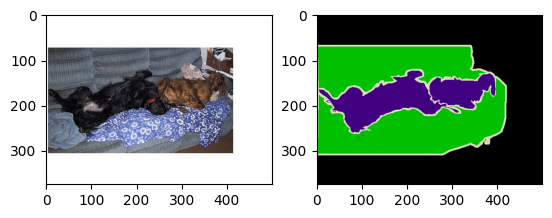

In [9]:
valset_raw = VOCSegmentation(DATA_ROOT, VOC_YEAR, "val", download=False)

image, mask = valset_raw[random.randint(0, len(valset_raw) - 1)]
print("Mask values:", set(np.array(mask).flatten().tolist()))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[1].imshow(mask)
plt.show()

Маска содержит номера классов для каждого пикселя. Имеется две специальные метки: 0 для фона и 255 для контура. Контур мы уберем.

In [10]:
for _ in range(5):
    i = random.randint(0, len(valset_raw) - 1)
    print("Image {:05d} size: {}".format(i, valset_raw[i][0].size))

Image 01085 size: (500, 375)
Image 00942 size: (500, 375)
Image 00254 size: (500, 334)
Image 00526 size: (500, 375)
Image 00470 size: (500, 375)


Заметим:
* Сеть U-Net способна обрабатывать изображения разных размеров, однако из изображений разного размера нельзя составить однородный тензор батча. Значит, изображения разного размера затруднят тренировку.

* Сеть U-Net является полностью сверточной сетью без паддинга, значит каждый нейрон видит лишь часть картинки и не зависит от положения на изображении и близости к границе.

* Область внимания каждого нейрона задается в пикселях. Значит, чем меньше изображение, тем больше информации о сцене получает каждый нейрон.



В корпусе содержатся изображения разного размера. Можно пойти разными путями:
1. привести изображения к одному размеру масштабированием без сохранения пропорций,
2. привести изображения к одному размеру масштабированием с сохранением пропорций,
3. привести изображения к одному размеру, вырезая случайные части,
4. использовать модели, которые могут работать с разными размерами.

Мы воспользуемся вторым вариантом.

При масштабировании изображений с сохранением пропорций и встравивании их в квадратные изображения, образуются пустые области. Пустые области будем заполнять зеркальными отражениями.

In [11]:
class Scaler(object):
    """Отмасштабировать изображения сохранив пропорции.

    Пустые места будут заполнены отражениями.

    Аргументы:
        image: Изображение в HWC формате.
        size: Требуемый размер, пара W, H.
    """
    def __init__(self, size):
        self._size = size
        self._padding = 0

    def set_padding(self, padding):
        self._padding = padding

    def __call__(self, image):
        if not isinstance(image, np.ndarray):
            image = np.array(image)
        grayscale = (len(image.shape) == 2)
        if grayscale:
            image = image[..., None]
        rw, rh = self._size
        p = self._padding
        h, w, c = image.shape
        scale_x = rw / w
        scale_y = rh / h
        scale = min(scale_x, scale_y)
        sw = int(scale * w)
        sh = int(scale * h)
        offset_x = p + (rw - sw) // 2
        offset_y = p + (rh - sh) // 2
        # Используем zeros на случай маленьких изображений.
        result = np.zeros((rh + 2 * p, rw + 2 * p, c), dtype=image.dtype)
        cv2.resize(image, (sw, sh),
                   interpolation=cv2.INTER_NEAREST if grayscale else cv2.INTER_AREA,
                   dst=result[offset_y:offset_y + sh, offset_x:offset_x + sw])

        # Отразить.
        result[offset_y:offset_y + sh, :offset_x] = result[offset_y:offset_y + sh, offset_x:2 * offset_x][:, ::-1]
        offset_end = result.shape[1] - offset_x - sw
        result[offset_y:offset_y + sh, offset_x + sw:] = result[offset_y:offset_y + sh, sw + offset_x - offset_end:sw + offset_x][:, ::-1]

        result[:offset_y] = result[offset_y:2 * offset_y][::-1]
        offset_end = result.shape[0] - offset_y - sh
        result[offset_y + sh:] = result[sh + offset_y - offset_end:sh + offset_y][::-1]

        if grayscale:
            result = result[:, :, 0]
        return result


def remove_borders_inplace(mask):
    mask[mask == 255] = 0
    return mask

Аугментации изображений:

In [12]:
class AffineAugmenter(object):
    def __init__(self, min_scale=0.9, max_offset=0.1, rotate=True):
        self._min_scale = min_scale
        self._max_offset = max_offset
        self._rotate = rotate

    def __call__(self, image, mask):
        image = np.array(image)  # PIL -> Numpy.
        mask = np.array(mask)
        h, w, c = image.shape
        assert c == 3
        if self._rotate:
            angle = random.random() * np.pi / 2 - np.pi / 4
        else:
            angle = 0
        scale = self._min_scale + random.random() * (1 - self._min_scale)
        rotation = cv2.getRotationMatrix2D(((w // 2), (h // 2)), angle * 180 / np.pi, scale)
        x_offset = random.randint(-int(self._max_offset * w), int(self._max_offset * w))
        y_offset = random.randint(-int(self._max_offset * h), int(self._max_offset * h))
        rotation[:, 2] += [x_offset, y_offset]
        new_image = cv2.warpAffine(image, rotation, (w, h), borderValue=(128, 128, 128))
        new_mask = cv2.warpAffine(mask, rotation, (w, h), borderValue=(0, 0, 0), flags=cv2.INTER_NEAREST)
        return new_image, new_mask  # Numpy -> PIL.


class BrightnessContrastAugmenter(object):
    def __init__(self, brightness=0.3, contrast=0.3):
        self._brightness = brightness
        self._contrast = contrast

    def __call__(self, image, mask):
        image = np.array(image)  # PIL -> Numpy.
        h, w, c = image.shape
        assert c == 3
        brightness = 2 * (random.random() - 0.5) * self._brightness
        contrast = 1 + 2 * (random.random() - 0.5) * self._contrast
        new_image = image.astype(np.float16)
        new_image += 255 * brightness
        new_image = (new_image - 128) * contrast + 128
        return new_image.clip(0, 255).astype(np.uint8), mask  # Numpy -> PIL.


class BlurAugmenter(object):
    def __init__(self, max_kernel=5):
        self._max_kernel = max_kernel

    def __call__(self, image, mask):
        kernel = random.randint(0, self._max_kernel // 2) * 2 + 1
        if kernel == 1:
            return image, mask
        image = np.array(image)  # PIL -> Numpy.
        h, w, c = image.shape
        assert c == 3
        new_image = cv2.GaussianBlur(image, (kernel, kernel), sigmaX=kernel / 2)
        return new_image.clip(0, 255).astype(np.uint8), mask  # Numpy -> PIL.


class FlipAugmenter(object):
    def __call__(self, image, mask):
        a = random.randint(0, 3)
        if a == 0:
            image = np.flip(image, axis=0)
            mask = np.flip(mask, axis=0)
        elif a == 1:
            image = np.flip(image, axis=0)
            mask = np.flip(mask, axis=0)
            image = np.flip(image, axis=1)
            mask = np.flip(mask, axis=1)
        elif a == 2:
            image = np.flip(image, axis=1)
            mask = np.flip(mask, axis=1)
        return image, mask


class RandomAugmentation(object):
    def __init__(self, *augmenters):
        self._augmenters = list(augmenters)

    def __call__(self, image, mask):
        augmenter = random.choice(self._augmenters)
        return augmenter(image, mask)

In [13]:
def image_to_numpy(image):
    """Convert Torch tensor to Numpy image."""
    if isinstance(image, np.ndarray):
        return image
    if image.dtype == torch.float32:
        image = image - image.min()
        image = 255 * image / max(1e-6, image.max())
    return image.to(torch.uint8).permute(1, 2, 0).cpu().numpy()


def image_to_torch(image, device=None):
    """Convert Numpy image to Torch tensor."""
    if isinstance(image, torch.Tensor):
        return image
    if image.shape[-1] == 4:
        image = image[..., :3]
    result = torch.from_numpy(np.ascontiguousarray(image))
    if device is not None:
        result = result.to(device)
    result = result.permute(2, 0, 1)
    return result

In [14]:
class VOCDataset(torch.utils.data.Dataset):
    """Обертка для стандартного класса, которая форматирует данные."""
    def __init__(self, root, year, image_size,
                 multiclass=MULTICLASS,
                 download=False, augment=False,
                 train=False, train_fraction=0.8,
                 padding=0):
        """Создать корпус.

        Аргументы:
            root: Путь до папки для хранения данных.
            year: 2007 или 2012.
            image_size: Ширина и высота изображений.
            download: Скачать корпус, если он не найден в папке.
            augment: Применить аугментации.
            train: Выделить train часть, иначе validation.
            train_fraction: Доля тренировочных примеров.
            padding: Добавить дополнительный зеркальынй паддинг к изображению.
        """
        self._dataset = VOCSegmentation(root, str(year), "trainval", download=download)
        self._image_size = np.array(image_size)
        self._multiclass = multiclass
        self._padding = padding

        ids = list(range(len(self._dataset)))
        random.seed(0)
        random.shuffle(ids)
        train_size = int(len(ids) * train_fraction)
        self._indices = ids[:train_size] if train else ids[train_size:]

        self._image_scaler = Scaler(image_size)
        self._mask_scaler = Scaler(image_size)
        if augment:
            self._augmenter = RandomAugmentation(AffineAugmenter(),
                                                 BrightnessContrastAugmenter(),
                                                 BlurAugmenter(),
                                                 FlipAugmenter())
        else:
            self._augmenter = lambda image, mask: (image, mask)

    @property
    def image_size(self):
        return self._image_size + self._padding * 2

    def set_padding(self, padding):
        self._padding = padding
        self._image_scaler.set_padding(padding)
        self._mask_scaler.set_padding(padding)

    def __len__(self):
        return len(self._indices)

    def __getitem__(self, idx):
        image, mask = self._dataset[self._indices[idx]]
        image = np.asarray(image)
        mask = np.array(mask)
        remove_borders_inplace(mask)
        if not self._multiclass:
            mask[mask > 0] = 1
        image = self._image_scaler(image)
        mask = self._mask_scaler(mask)
        image, mask = self._augmenter(image, mask)
        image = image_to_torch(image).float() - 0.5
        mask = image_to_torch(mask[..., None]).long()[0]
        return image, mask

IMAGE_SIZE = 512  # В исходной статье U-Net применяется к изображениям размера 572.

# Корпус был загружен выше, download = False.
trainset = VOCDataset(DATA_ROOT, VOC_YEAR, (IMAGE_SIZE, IMAGE_SIZE),
                      multiclass=MULTICLASS, train=True)
valset = VOCDataset(DATA_ROOT, VOC_YEAR, (IMAGE_SIZE, IMAGE_SIZE),
                    multiclass=MULTICLASS, train=False)
print("Image size:", IMAGE_SIZE)
print("Train set size:", len(trainset))
print("Validation set size:", len(valset))

Image size: 512
Train set size: 2330
Validation set size: 583


Корпус очень маленький.
1. Мы будем учить сеть, состоящую только из сверток. У таких сетей относительно мало параметров и они могут обучаться на небольших корпусах.
2. Каждый пиксель - отдельная метка. Количество пикселей в корпусе огромно, в этом смысле корпус большой.
3. Добавим аугментации

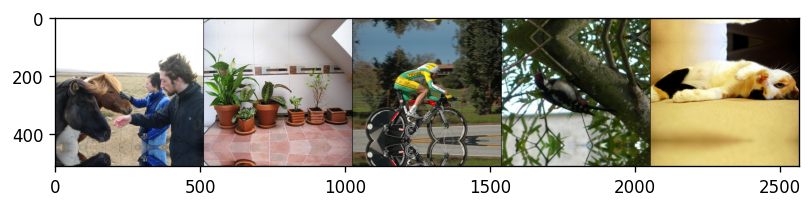

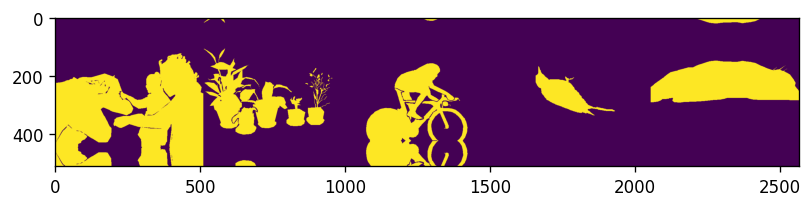

In [15]:
def show_dataset(dataset):
    images = []
    masks = []
    for _ in range(5):
        i = random.randint(0, len(valset) - 1)
        if len(images):
            separator = np.zeros((dataset.image_size[0], 2, 3), dtype=np.uint8)
            images.append(separator)
            masks.append(separator[:, :, 0])
        image, mask = dataset[i]
        images.append(image_to_numpy(image))
        masks.append(image_to_numpy(mask[None, ...])[..., 0])

    %matplotlib inline
    set_figure_size()
    plt.imshow(np.concatenate(images, axis=1))
    plt.show()
    set_figure_size()
    plt.imshow(np.concatenate(masks, axis=1))
    plt.show()

valset.set_padding(0)
show_dataset(trainset)



---



### 1.2 Создание модели



Создадим сеть вида [U-Net](https://arxiv.org/pdf/1505.04597)

Сеть U-Net состоит из двух частей. Первая часть строит эмбеддинг. Вторая часть зарисовывает изображение и имеет структуру, похожую на первую часть. Первая часть использует max pooling и сжимает изображение, а вторая разжимает за счет транспонированной свертки. Из-за этого возникает параллель между слоями первой и второй части: они имеют схожий размер тензоров. По этой причине мы можем использовать выходы слоев первой части в качестве входов для слоев второй части. Информация из первой части, в которой сохраняются небольшие детали изображения, без труда используется при зарисовке, что приводит к повыжению детализации маски.

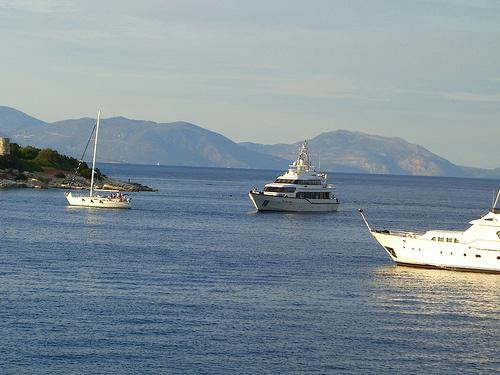


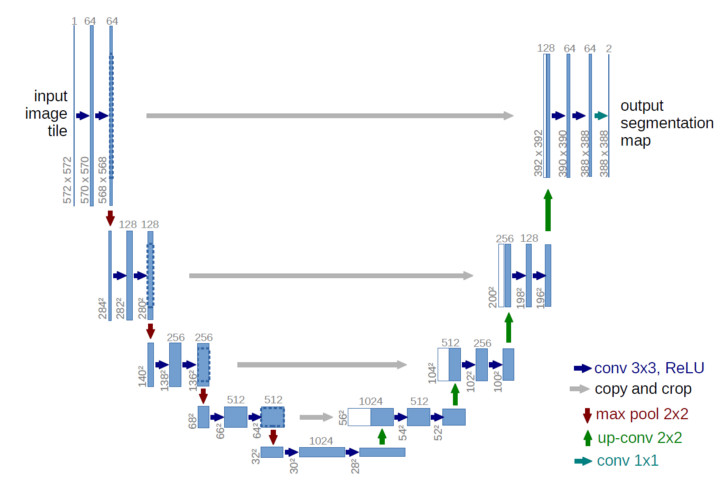


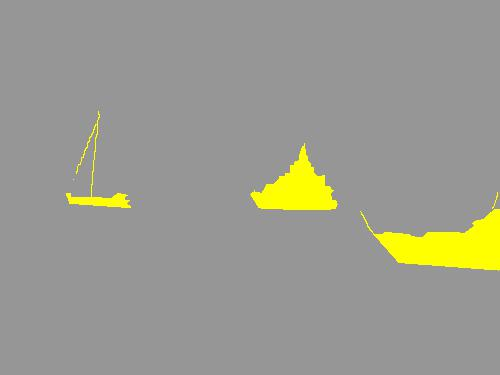

<div style="clear:both;"></div>



Заметьте, что размер выходного тензора меньше, чем размер исходного. В сети не используется паддинг, что позволяет сделать выход независящим от позиции на изображении. В оригинальной статье сеть используется для сегментации больших изображений методом скользящего окна. При этом на границе используется зеркальный padding, размер которого определяется receptive field сети
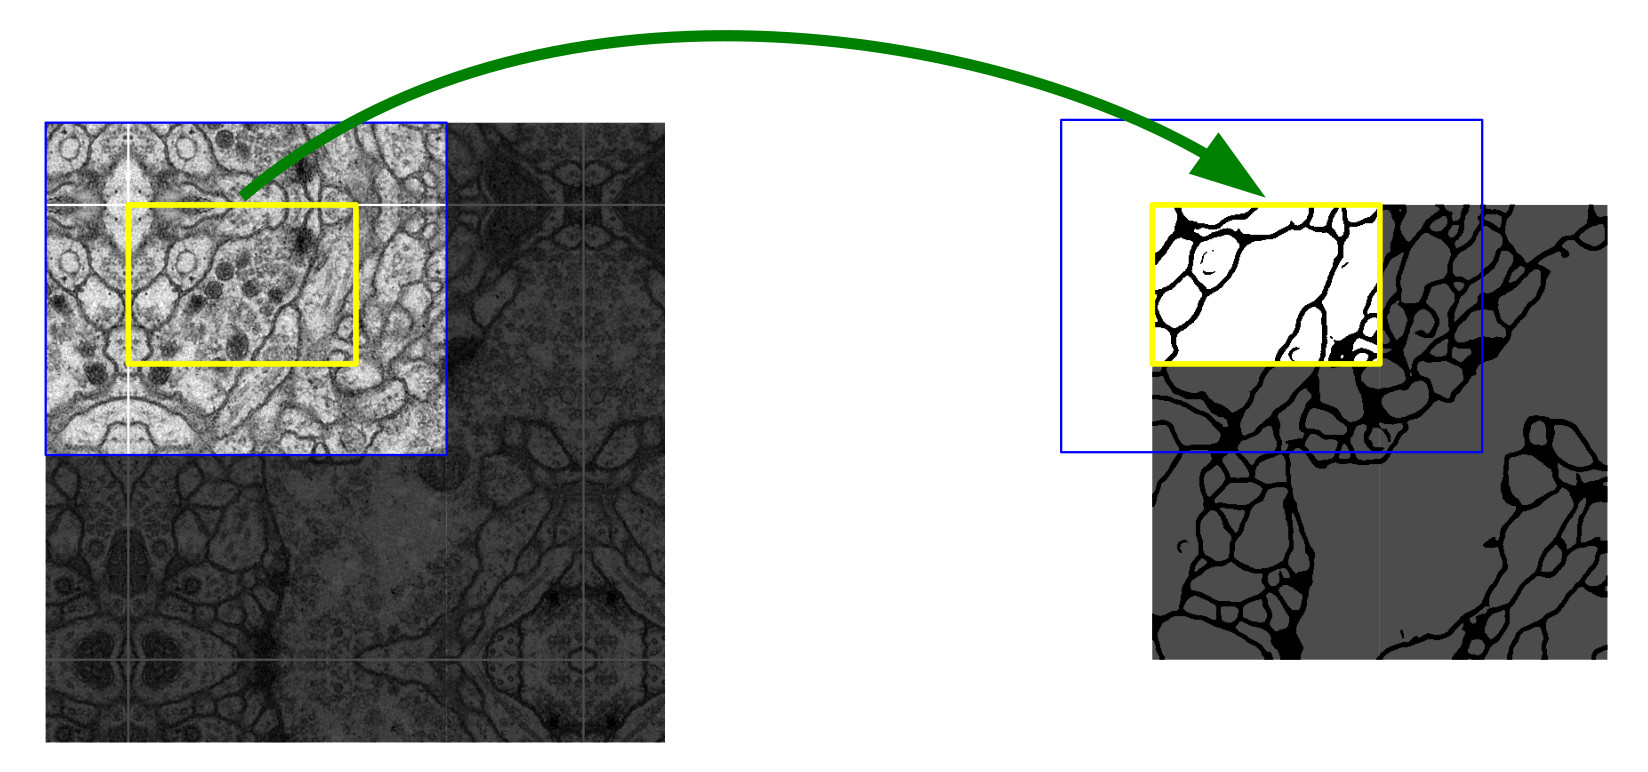

Мы внесем несколько изменений в U-Net для ускорения тренировки и повышения качества:

+ Будем использовать меньший размер изображений и меньший размер сети.
+ Добавим residual connections.
+ Добавим batch normalization.

In [ ]:
def make_conv1x1(in_channels, out_channels):
    """Создать слой свертки 1x1."""
    # Начало вашего кода.


    # Конец вашего кода.

    return layer

def make_transposed_convolution2x2(in_channels, out_channels):
    """Создать транспонированную свертку (AKA deconvolution, upconvolution)."""

    # Обратите внимание на параметр output_padding. Поскольку stride в maxpooling
    # может давать один и тот же размер выхода для разных размеров входа, необходимо
    # указать такую добавку к размерности, чтобы получился тензор той же размерности,
    # что и в первой части сети.
    #
    # Поскольку у нас размер изображения всегда четный,
    # output_padding нужно выставить в 0.

    # Начало вашего кода.


    # Конец вашего кода.

    return layer

def make_conv3x3(in_channels, out_channels, bias=True):
    return torch.nn.Conv2d(in_channels, out_channels, 3, bias=bias)

def make_batchnorm(channels):
    return torch.nn.BatchNorm2d(channels)

def make_relu():
    return torch.nn.ReLU(inplace=True)

def make_maxpool2x2():
    return torch.nn.MaxPool2d(2)

In [ ]:
class ConvBlock(torch.nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            make_conv3x3(in_channels, out_channels, bias=False),
            make_batchnorm(out_channels),
            make_relu(),
            make_conv3x3(out_channels, out_channels, bias=False),
            make_batchnorm(out_channels),
            make_relu()
        )

class ResConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.main_path = torch.nn.Sequential(
            make_conv3x3(in_channels, out_channels, bias=False),
            make_batchnorm(out_channels),
            make_relu(),
            make_conv3x3(out_channels, out_channels, bias=False),
            make_batchnorm(out_channels)
        )
        self.residual_path = make_conv1x1(in_channels, out_channels)
        self.last_relu = make_relu()

    def forward(self, x):
        result = self.main_path(x)
        residual = self.residual_path(x)[:, :, 2:-2, 2:-2]
        result = self.last_relu(result + residual)
        return result

Мы реализуем два класса:
+ `Down` реализует преобразование между двумя max pooling,
при этом начинается с max pooling. Первые две свертки сети в него не входят.
+ `Up` реализует преобразование между двумя транспонированными свертками и начинает с транспонированной свертки. Последняя свертка сети в него не входит.

In [ ]:
class UNetDown(torch.nn.Sequential):
    """Часть сети между двумя max pooling, которая начинается с max pooling."""
    def __init__(self, in_channels, out_channels, block):
        layers = [
            make_maxpool2x2(),
            block(in_channels, out_channels)
        ]
        super().__init__(*layers)


class UNetUp(torch.nn.Module):
    """Часть сети между двумя транспонированными свертками, которая начинается с
    транспонированной свертки."""
    def __init__(self, in_channels, out_channels, block):
        super().__init__()
        self._transposed_convolution = make_transposed_convolution2x2(in_channels, out_channels)
        self._convolutions = block(out_channels * 2, out_channels)

    def forward(self, x_down, x_up):
        x_up = self._transposed_convolution(x_up)

        b_down, c_down, h_down, w_down = x_down.shape
        b_up, c_up, h_up, w_up = x_up.shape
        if (h_up > h_down) or (w_up > w_down):
            raise ValueError("Up tensor must be smaller than down tensor")
        offset = ((h_down - h_up) // 2, (w_down - w_up) // 2)
        x_down_cropped = x_down[:, :, offset[0]:offset[0] + h_up, offset[1]:offset[1] + w_up]

        x = torch.cat((x_down_cropped, x_up), axis=1)
        result = self._convolutions(x)
        return result

**Схема модели:**

input -> conv -> conv -> Down x 4 -> Up x 4 -> conv -> output.

In [ ]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes, num_scales=4, base_filters=64, block=ConvBlock):
        """Создать U-Net сеть.

        Параметры:
            num_classes: Число классов на выходе. Для классификации объект/фон нужно два класса.
            num_scales: Число блоков U-Net сети, выполняющих изменение размера изображения.
            base_filters: Число фильтров на первом уровне сети.
        """
        super().__init__()
        self._input_convolutions = block(3, base_filters)

        layers = []
        filters = base_filters
        for i in range(num_scales):
            layers.append(UNetDown(filters, filters * 2, block))
            filters *= 2
        self._down_layers = torch.nn.Sequential(*layers)

        layers = []
        for i in range(num_scales):
            layers.append(UNetUp(filters, filters // 2, block))
            filters //= 2
        self._up_layers = torch.nn.Sequential(*layers)

        self._output_convolution = make_conv1x1(filters, num_classes)
        self.initialize_weights()

        # Оценим насколько сеть уменьшает изображение.
        self.eval()
        sample_input = torch.zeros((1, 3, 1000, 1000))
        if USE_CUDA:
            sample_input = sample_input.cuda()
            self.cuda()
        with torch.no_grad():
            sample_output = self(sample_input)
        self.padding = (sample_input.shape[-1] - sample_output.shape[-1]) // 2

    def forward(self, x):
        down_results = [self._input_convolutions(x)]
        for layer in self._down_layers:
            down_results.append(layer(down_results[-1]))
        x = down_results[-1]
        for i, layer in enumerate(self._up_layers):
            x = layer(down_results[-2 - i], x)
        x = self._output_convolution(x)
        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (torch.nn.Conv2d, torch.nn.ConvTranspose2d)):
                torch.nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

def count_parameters(model):
    total = 0
    for p in model.parameters():
        total += np.prod(list(p.shape))
    return total

USE_RESIDUALS = True

unet = UNet(NUM_CLASSES if NUM_CLASSES > 2 else 1,
            num_scales=4,  # Число блоков U-Net сети, в статье 4.
            base_filters=64,  # Размер свертки на первом уровне, в статье 64.
            block=ResConvBlock if USE_RESIDUALS else ConvBlock)

print(unet)
print("Required padding: {}".format(unet.padding))
print("Total parameters: {}".format(count_parameters(unet)))



---



### 1.3 Обучение

Создадим класс для подсчета функции потерь - бинарной перекрестной энтропии.

In [ ]:
def crop_images(predicted, masks_or_images):
    """Если выход больше или меньше чем исходное изображение,
    вырезать центральную часть из обоих, чтобы размеры совпадали.
    """
    if len(masks_or_images.shape) == 3:
        predicted, masks = crop_images(predicted, masks_or_images.unsqueeze(1))
        return predicted, masks[:, 0]
    images = masks_or_images
    if (len(predicted.shape) != 4) or (len(images.shape) != 4):
        raise ValueError("Expected tensors of shape BCHW")
    bi, ci, hi, wi = images.shape
    bp, cp, hp, wp = predicted.shape
    offset = (abs(hi - hp) // 2, abs(wi - wp) // 2)
    if hp < hi:
        images = images[:, :, offset[0]:offset[0] + hp]
    else:
        predicted = predicted[:, :, offset[0]:offset[0] + hi]
    if wp < wi:
        images = images[:, :, :, offset[1]:offset[1] + wp]
    else:
        predicted = predicted[:, :, :, offset[1]:offset[1] + wi]
    return predicted, images

In [ ]:
class BCELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Ваш код здесь.

        # Конец вашего кода.

    def __call__(self, predicted, masks):
        predicted, masks = crop_images(predicted, masks)
        b, c, h, w = predicted.shape
        if c != 1:
            raise ValueError("{} не подходит для многоклассовой классификации".format(type(self)))

        # predicted: float32, BCHW.
        # masks: long, BHW.

        # Ваш код здесь.

        # Конец вашего кода.

        return loss

In [ ]:
class XentLoss(torch.nn.Module):
    """Функция потерь для сегментации с несколькими классами."""
    def __init__(self):
        super().__init__()
        self._xent = torch.nn.CrossEntropyLoss()

    def __call__(self, predicted, masks):
        predicted, masks = crop_images(predicted, masks)
        b, c, h, w = predicted.shape
        if c == 1:
            raise ValueError("{} не подходит для бинарной классификации".format(type(self)))
        predicted = predicted.permute(0, 2, 3, 1).reshape(b * h * w, c)
        masks = masks.reshape(-1)
        loss = self._xent(predicted, masks)
        return loss

In [ ]:
def make_optimizer(model):
    return torch.optim.Adam(model.parameters(), lr=1e-4)

Обучение

In [ ]:
class Module(pl.LightningModule):
    def __init__(self, model, loss_fn, optimizer_fn, trainset, testset,
                 lr_scheduler_fn=None,
                 batch_size=16):
        super().__init__()
        self._model = model
        self._optimizer_fn = optimizer_fn
        self._lr_scheduler_fn = lr_scheduler_fn
        self._criterion = loss_fn()
        self._batch_size = batch_size
        self._trainset = trainset
        self._testset = testset

    def forward(self, input):
        return self._model(input)

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop. It is independent of forward
        x, y = batch
        logits = self._model(x)
        loss = self._criterion(logits, y)
        self.logger.experiment.add_scalars("loss",
                                           {"train": loss},
                                           global_step=self.global_step)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self._model(x)
        loss = self._criterion(logits, y)
        self.logger.experiment.add_scalars("loss",
                                           {"val": loss},
                                           global_step=self.global_step)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self._trainset, batch_size=self._batch_size, shuffle=True, drop_last=True, num_workers=2)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self._testset, batch_size=self._batch_size, shuffle=False, num_workers=2)

    def configure_optimizers(self):
        optimizer = self._optimizer_fn(self._model)
        scheduler = self._lr_scheduler_fn(optimizer)
        if scheduler:
            return [optimizer], [scheduler]
        else:
            return optimizer


def train_model(model, loss_fn, optimizer_fn, trainset, testset,
                lr_scheduler_fn=None,
                batch_size=4,
                eval_steps=250,
                num_epochs=1):
    model = Module(model, loss_fn, optimizer_fn, trainset, testset,
                   lr_scheduler_fn, batch_size)
    trainer = pl.Trainer(gpus=int(torch.cuda.is_available()), max_epochs=num_epochs, val_check_interval=eval_steps)
    trainer.fit(model)

In [ ]:
loss_fn = BCELoss if NUM_CLASSES == 2 else XentLoss

trainset.set_padding(unet.padding)
valset.set_padding(unet.padding)
train_model(unet, loss_fn, make_optimizer, trainset, valset,
            lr_scheduler_fn=lambda opt: None,
            eval_steps=500,
            batch_size=4)

Посмотрим на логи обучения

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir ./lightning_logs



---



### 1.4 Визуализация результатов

In [ ]:
def show_segmentations(model, dataset, n=5):
    model.eval()
    if USE_CUDA:
        model.cuda()
    for _ in range(n):
        image, mask_gt = dataset[random.randint(0, len(dataset) - 1)]
        if USE_CUDA:
            image = image.cuda()
            mask_gt = mask_gt.cuda()
        with torch.no_grad():
            predicted = model(image.unsqueeze(0))[0]  # CHW.
            predicted, image = crop_images(predicted.unsqueeze(0), image.unsqueeze(0))
            predicted, image = predicted[0], image[0]
            c = predicted.shape[0]
            if c == 1:
                predicted = torch.nn.functional.logsigmoid(predicted)
                aggregated = predicted[0]
                predicted_labels = predicted[0] > np.log(0.5)
            else:
                predicted = torch.nn.functional.log_softmax(predicted, 0)
                aggregated = torch.logsumexp(predicted[1:], axis=0)
                predicted_labels = predicted.max(0)[1]
        aggregated = aggregated.cpu().numpy()
        predicted_labels = predicted_labels.cpu().numpy().astype(np.uint8)
        image = image_to_numpy(image)
        mask = (predicted_labels > 0)[..., None]
        selected = image * mask + 255 * (1 - mask)

        %matplotlib inline
        if c != 1:
            print("Classes:", [LABELS[i] for i in set(predicted_labels.flatten().tolist())])
        set_figure_size()
        fig, axs = plt.subplots(1, 4, figsize=(12, 6))
        axs[0].imshow(image)
        axs[1].imshow(predicted_labels)
        axs[2].imshow(aggregated)
        axs[3].imshow(selected)
        plt.show()

In [ ]:
print("Trainset")
show_segmentations(unet, trainset)

print("Valset")
show_segmentations(unet, valset)



---


### 1.5 Задание: Semantic Segmentation (5 баллов)

1. Добавьте понятные метрики на валидацию (mean-IoU)
2. Возьмите любой предобученный U-Net, покажите, как он работает до вашего обучения, дообучите несколько эпох с BCE и покажите результат
3. Добавьте лосс Jaccard или DICE loss к BCE, обучите модель с ним и проанализируйте результат
4. Дополните список аугментаций (>= 2) и исследуйте их влияние на итоговый результат

В итоге необходимо показать результаты работы - графики mean-IoU, лосс и примеры работы модели, а также написать полученные выводы

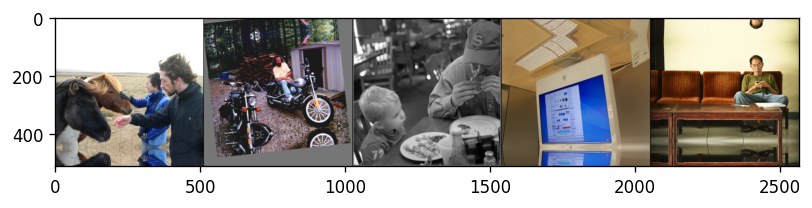

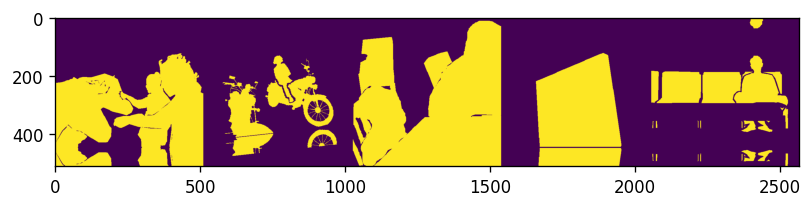

In [16]:
trainset_augmented = VOCDataset(DATA_ROOT, VOC_YEAR, (IMAGE_SIZE, IMAGE_SIZE),
                                multiclass=MULTICLASS, train=True, augment=True)
show_dataset(trainset_augmented)

Training with CrossEntropy Loss...


100%|██████████| 292/292 [01:01<00:00,  4.77it/s]


Epoch 1/10, Train Loss: 0.3377, Val Loss: 0.2657, mean IoU: 0.5763


100%|██████████| 292/292 [00:57<00:00,  5.09it/s]


Epoch 2/10, Train Loss: 0.2655, Val Loss: 0.2557, mean IoU: 0.6118


100%|██████████| 292/292 [00:56<00:00,  5.15it/s]


Epoch 3/10, Train Loss: 0.2445, Val Loss: 0.2250, mean IoU: 0.6276


100%|██████████| 292/292 [00:56<00:00,  5.21it/s]


Epoch 4/10, Train Loss: 0.2258, Val Loss: 0.2342, mean IoU: 0.6413


100%|██████████| 292/292 [00:56<00:00,  5.13it/s]


Epoch 5/10, Train Loss: 0.2089, Val Loss: 0.2283, mean IoU: 0.6454


100%|██████████| 292/292 [00:55<00:00,  5.22it/s]


Epoch 6/10, Train Loss: 0.1986, Val Loss: 0.2322, mean IoU: 0.6274


100%|██████████| 292/292 [00:56<00:00,  5.15it/s]


Epoch 7/10, Train Loss: 0.1883, Val Loss: 0.2130, mean IoU: 0.6598


100%|██████████| 292/292 [00:56<00:00,  5.19it/s]


Epoch 8/10, Train Loss: 0.1755, Val Loss: 0.2300, mean IoU: 0.6432


100%|██████████| 292/292 [00:55<00:00,  5.23it/s]


Epoch 9/10, Train Loss: 0.1705, Val Loss: 0.2296, mean IoU: 0.6600


100%|██████████| 292/292 [00:57<00:00,  5.10it/s]


Epoch 10/10, Train Loss: 0.1766, Val Loss: 0.2205, mean IoU: 0.6578


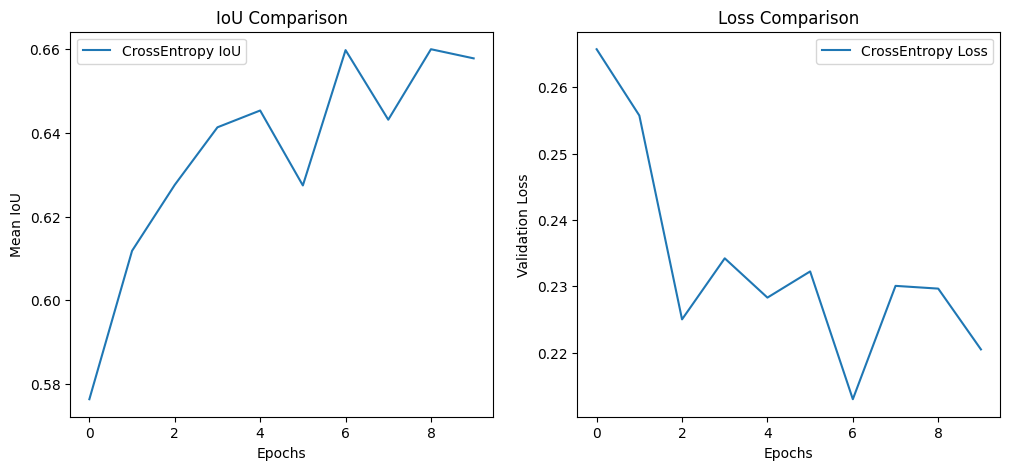

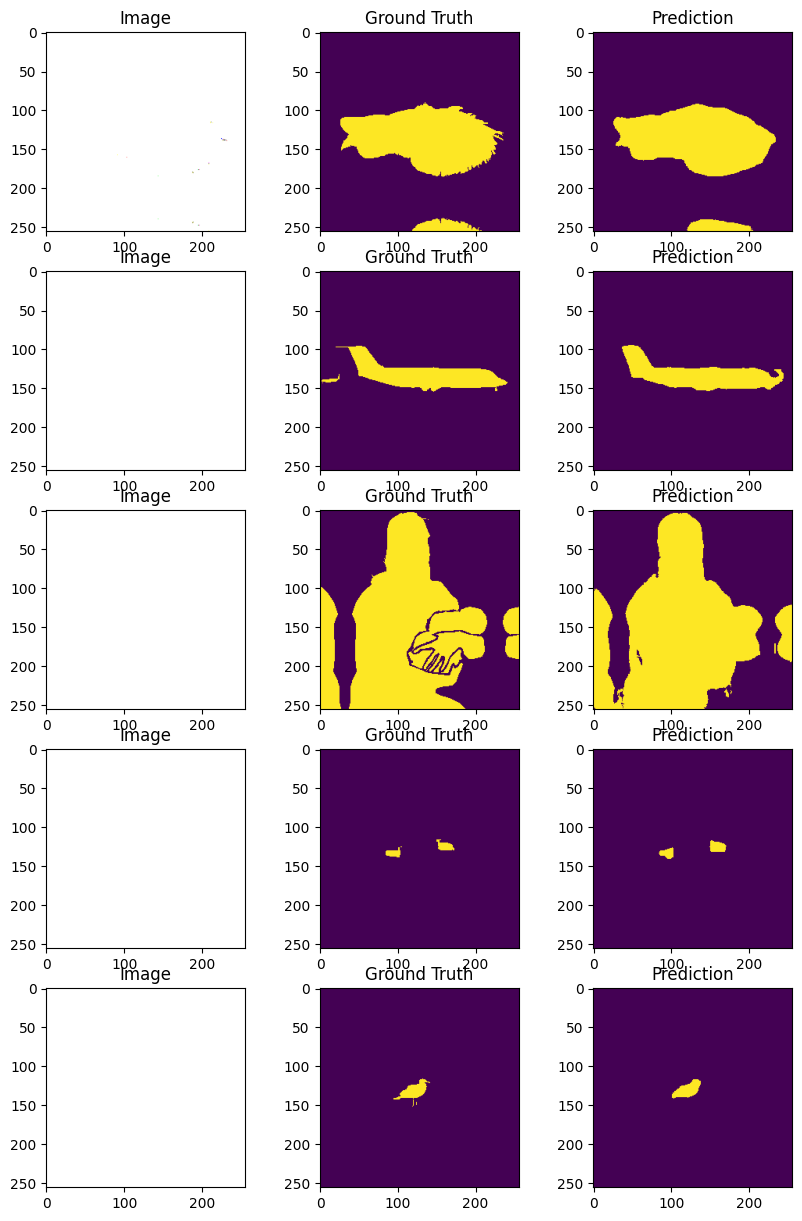

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import albumentations as A
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from segmentation_models_pytorch import Unet
from segmentation_models_pytorch.losses import JaccardLoss, DiceLoss
from torchmetrics import JaccardIndex
from torchvision.transforms import ToTensor
from PIL import Image
from tqdm import tqdm
import torchvision.transforms as T


def get_datasets():
    train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(),
    ])

    val_transform = A.Compose([A.Normalize()])

    trainset = VOCDataset(DATA_ROOT, VOC_YEAR, (256, 256), multiclass=MULTICLASS, train=True, augment=True)
    valset = VOCDataset(DATA_ROOT, VOC_YEAR, (256, 256), multiclass=MULTICLASS, train=False, augment=False)

    return trainset, valset

trainset, valset = get_datasets()
train_loader = DataLoader(trainset, batch_size=8, shuffle=True)
val_loader = DataLoader(valset, batch_size=8, shuffle=False)
model = Unet("resnet34", encoder_weights="imagenet", classes=NUM_CLASSES, activation=None).cuda()

def evaluate(model, dataloader):
    model.eval()
    iou_metric = JaccardIndex(task="binary" if not MULTICLASS else "multiclass", num_classes=NUM_CLASSES).cuda()
    mean_iou = []
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.cuda(), masks.cuda()
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            mean_iou.append(iou_metric(preds, masks).item())
    return np.mean(mean_iou)

def train(model, train_loader, val_loader, epochs=10, loss_fn=nn.CrossEntropyLoss(), lr=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses, iou_scores = [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, masks in tqdm(train_loader):
            images, masks = images.cuda(), masks.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_loss = evaluate_loss(model, val_loader, loss_fn)
        iou_score = evaluate(model, val_loader)
        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss)
        iou_scores.append(iou_score)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, mean IoU: {iou_scores[-1]:.4f}")

    return train_losses, val_losses, iou_scores

def evaluate_loss(model, dataloader, loss_fn):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.cuda(), masks.cuda()
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            total_loss += loss.item()
    return total_loss / len(dataloader)

print("Training with CrossEntropy Loss...")
crossentropy_loss = nn.CrossEntropyLoss()
crossentropy_train_losses, crossentropy_val_losses, crossentropy_iou = train(model, train_loader, val_loader, loss_fn=crossentropy_loss)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(crossentropy_iou, label="CrossEntropy IoU")
plt.xlabel("Epochs")
plt.ylabel("Mean IoU")
plt.legend()
plt.title("IoU Comparison")

plt.subplot(1, 2, 2)
plt.plot(crossentropy_val_losses, label="CrossEntropy Loss")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.title("Loss Comparison")
plt.show()

def show_predictions(model, dataloader, num_images=5):
    model.eval()
    images, masks = next(iter(dataloader))
    images, masks = images.cuda(), masks.cuda()
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 3))
    for i in range(num_images):
        axes[i, 0].imshow(images[i].permute(1, 2, 0).cpu())
        axes[i, 1].imshow(masks[i].cpu().squeeze())
        axes[i, 2].imshow(preds[i].cpu().squeeze())
        axes[i, 0].set_title("Image")
        axes[i, 1].set_title("Ground Truth")
        axes[i, 2].set_title("Prediction")
    plt.show()

show_predictions(model, val_loader)


In [ ]:
# просто пример, не обязательно брать resnet34
unet_pretrained = smp.Unet("resnet34", encoder_weights="imagenet", classes=NUM_CLASSES if NUM_CLASSES > 2 else 1)

unet_pretrained.eval()
sample_input = torch.zeros((1, 3, 1024, 1024))
if USE_CUDA:
    sample_input = sample_input.cuda()
    unet_pretrained.cuda()
with torch.no_grad():
    sample_output = unet_pretrained(sample_input)
pretrained_padding = (sample_input.shape[-1] - sample_output.shape[-1]) // 2
print(unet_pretrained)
print("Padding", pretrained_padding)



---



## 2. Metric Learning

Мы хотим обучить модель, которая могла бы переводить изображения в такое латентное простраство, где:

1. Изображения из одного класса (или похожие) находились бы близко друг к другу
2. Расстояния до разных изображений должны быть больше, чем до одинаковых



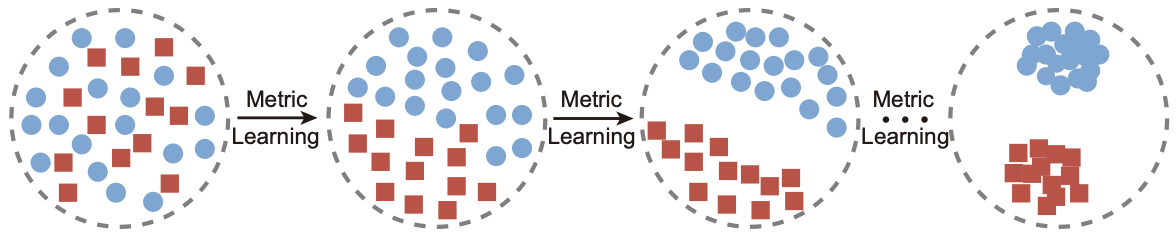

### 2.1 Подготовка данных

Будем использовать [классический для этой задачи](https://paperswithcode.com/sota/metric-learning-on-cars196) датасет СARS196

In [22]:
!kaggle datasets download eduardo4jesus/stanford-cars-dataset

Dataset URL: https://www.kaggle.com/datasets/eduardo4jesus/stanford-cars-dataset
License(s): unknown
100% 1.82G/1.82G [00:47<00:00, 45.1MB/s]
100% 1.82G/1.82G [00:47<00:00, 41.5MB/s]


In [ ]:
!unzip /content/stanford-cars-dataset.zip

In [24]:
mat = scipy.io.loadmat('/content/car_devkit/devkit/cars_train_annos.mat')
fname_to_class = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']],
                                                [i[0][0] for i in mat['annotations'][0]['class']])}
cars_meta = scipy.io.loadmat('/content/car_devkit/devkit/cars_meta.mat')
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

In [25]:
ADD_PATH = '/content/cars_train/cars_train'

Посмотрим на данные

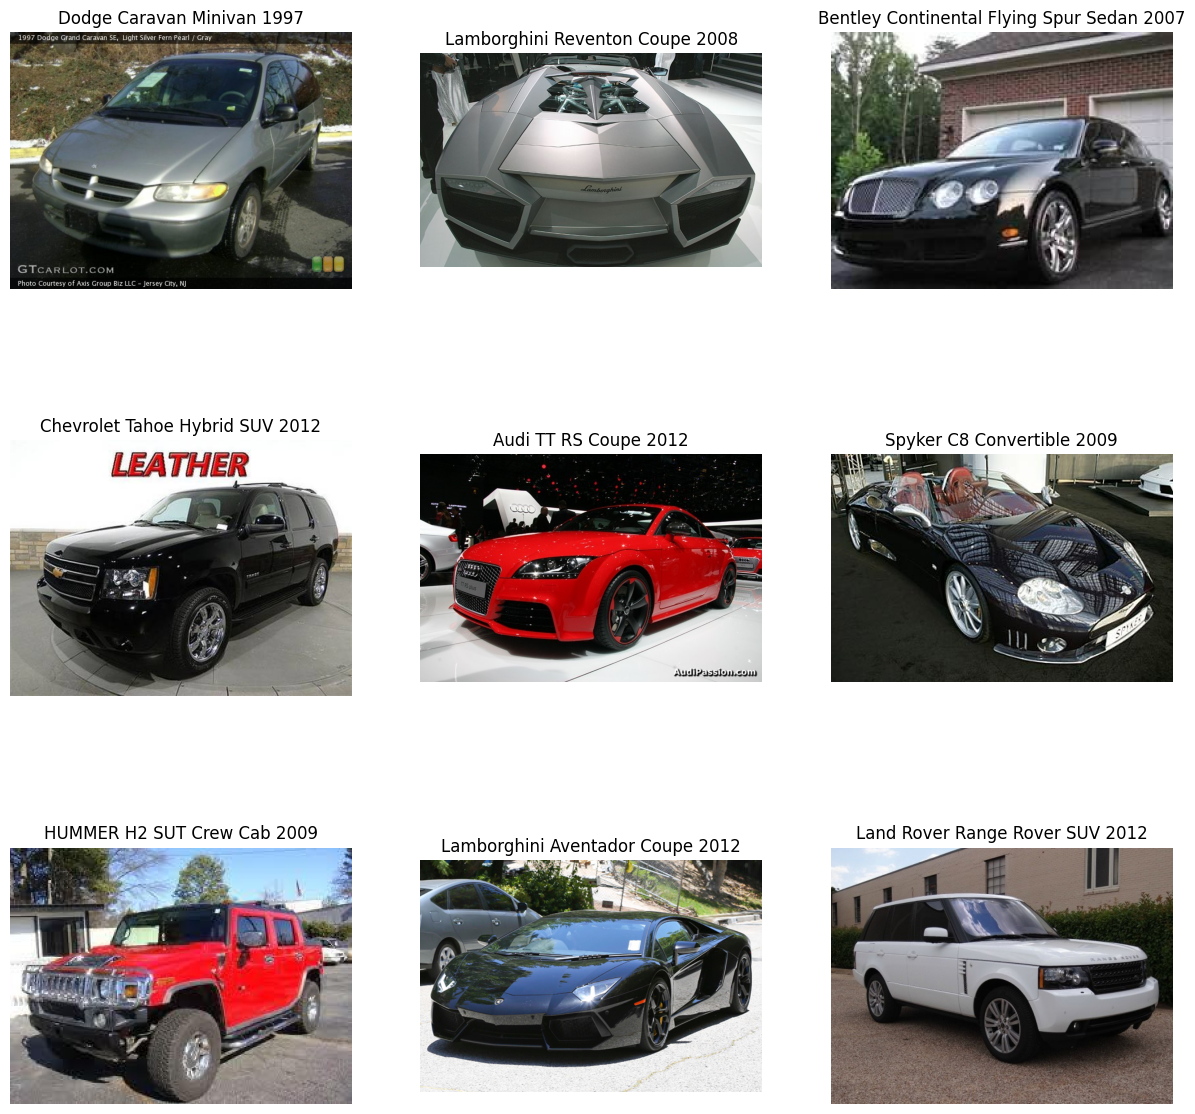

In [26]:
num_imgs = 9
cols = 3
rows = num_imgs // cols
fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
for idx, im_idx in enumerate(random.sample([i for i in range(len(fname_to_class))], num_imgs)):
    filename, cl_id = list(fname_to_class.items())[im_idx]
    temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
    temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
    ax[idx//cols][idx%cols].imshow(temp_image)
    ax[idx//cols][idx%cols].set_title(f'{id_to_car[cl_id]}')
    ax[idx//cols][idx%cols].axis('off')

Распределение по классам

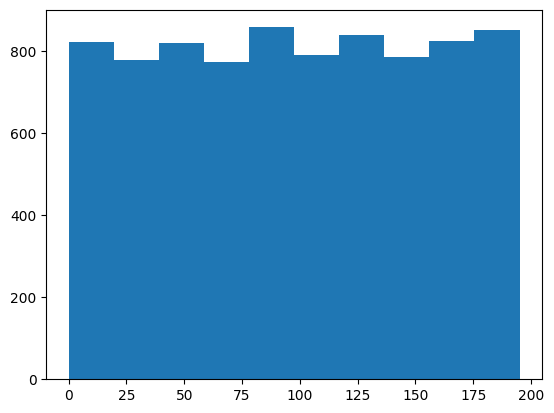

In [27]:
plt.hist(fname_to_class.values())
plt.show()

Подготовка данных для обучения

In [28]:
val_transforms =  torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.Resize(
                size=(224, 224)
            ),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
            ])

class CarsDataset(torch.utils.data.Dataset):
    def __init__(self, cars_items, transforms):
        self.cars = cars_items
        self.transforms = transforms

    def __len__(self):
        return len(self.cars)

    def __getitem__(self, idx):
        filename, cl_id = self.cars[idx]
        image = cv2.imread(os.path.join(ADD_PATH, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            image = self.transforms(image)
        sample = {'image': image, 'label': cl_id}
        return sample

In [29]:
items = list(fname_to_class.items())
random.shuffle(items)
train_items = items[:int(len(items) * 0.8)]
val_items = items[int(len(items) * 0.8):]

train_dataset = CarsDataset(train_items, val_transforms)
val_dataset = CarsDataset(val_items, val_transforms)

In [30]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, collate_fn=None, pin_memory=True, drop_last = True)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, collate_fn=None, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(




---



### 2.2 Функции потерь

Давайте посмотрим на [Center Loss](https://arxiv.org/pdf/1707.07391), напомню идею:

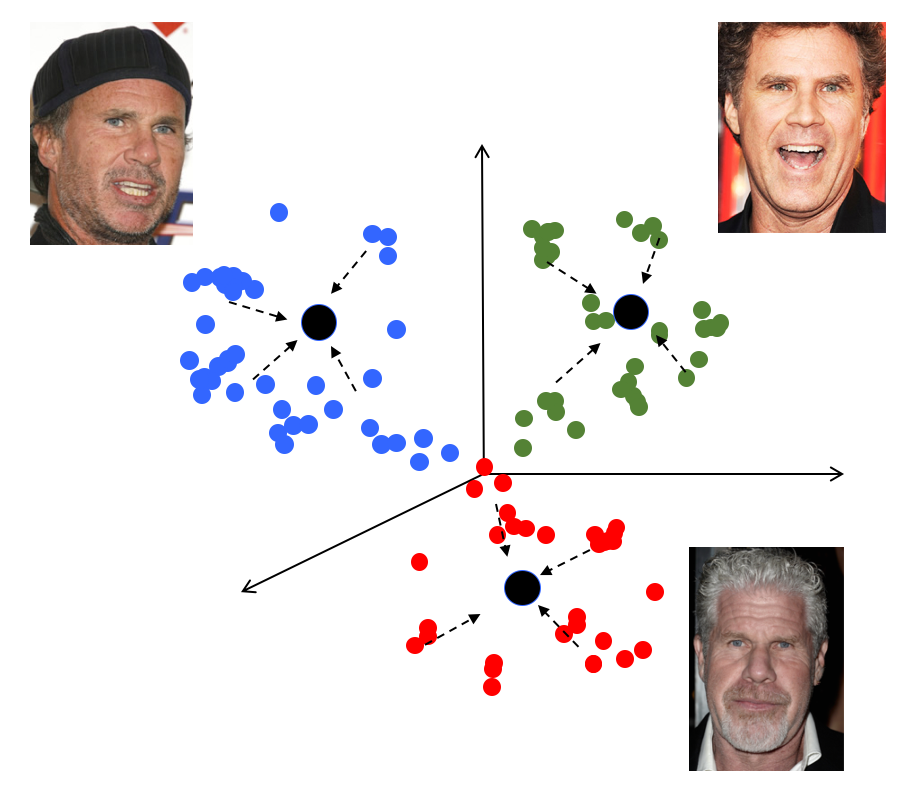

По сути мы используем два лосса:
 - дискриминационный (softmax), чтобы обеспечить разделяемость
 - стягивающий для компактности (center loss)


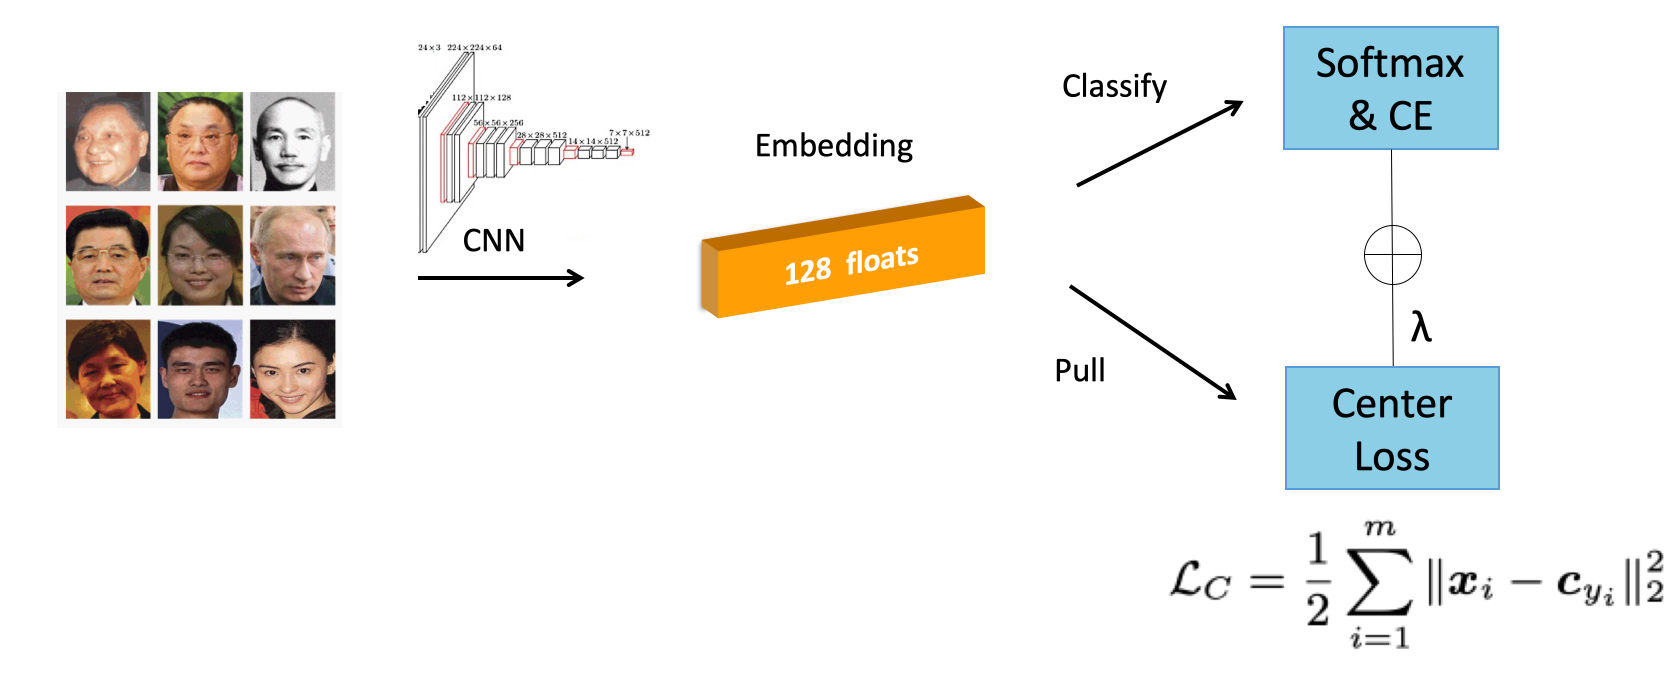

In [33]:
class CenterLoss(nn.Module):
    """Center loss.

    Reference:
    Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.

    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
    def __init__(self, num_classes=10, feat_dim=2, device='cpu'):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim

        self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))


    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        self.centers = self.centers.to(DEVICE)
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        classes = torch.arange(self.num_classes).long()
        classes = classes.to(DEVICE)
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

Основная идея [Arcface](https://arxiv.org/pdf/1801.07698) - оперировать на единичной окружности, где за разделимость
отвечает угол между векторами (весами линейного слоя) классов.

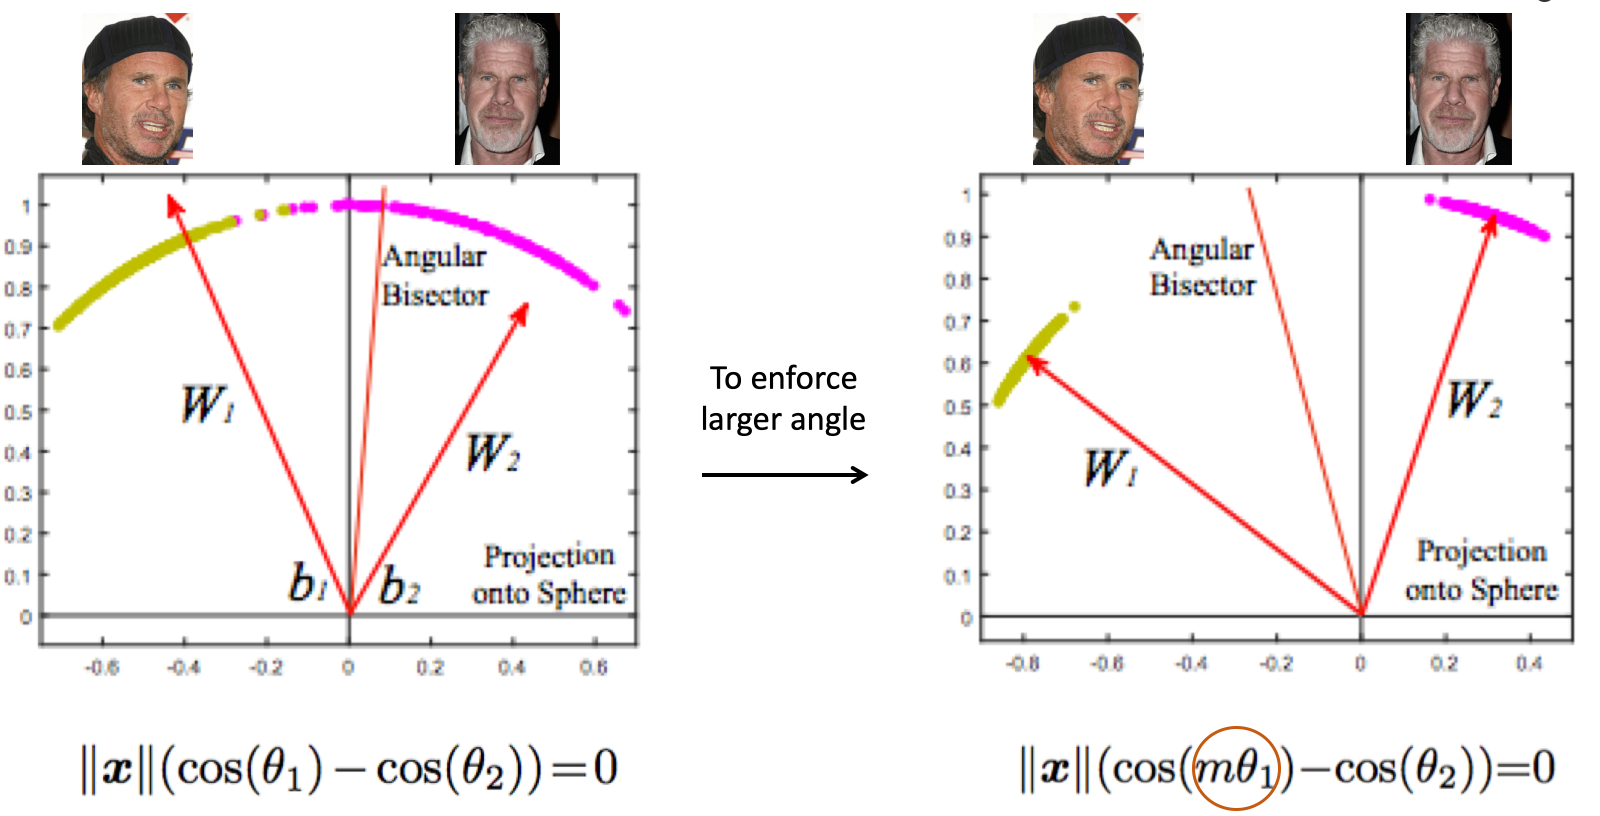



---



### 2.3 Обучение

In [34]:
class CarEmbedder(pl.LightningModule):
    def __init__(self, class_dict, learning_rate, emb_size):
        super().__init__()
        self.learning_rate = learning_rate
        self.model = resnet50(pretrained=True)

        self.model.fc = torch.nn.Sequential(
                            torch.nn.Linear(in_features=2048, out_features=emb_size))
        self.classifier_head = torch.nn.Sequential(
                            torch.nn.ReLU(),
                            torch.nn.Linear(in_features=emb_size, out_features=len(class_dict)))
        self.arc_face_loss = losses.ArcFaceLoss(len(class_dict), emb_size, margin=28.6, scale=64)
        self.classif_loss = torch.nn.CrossEntropyLoss()
        self.center_loss = CenterLoss(len(class_dict), emb_size, DEVICE)
        self.alpha = 0.4

        self.save_hyperparameters()

    def training_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label'].to(torch.long)
        preds = self.model(images)

        """
        ArcFace

        final_loss = self.arc_face_loss(preds, labels)
        """

        """
        CE + CenterLoss

        center_loss = self.center_loss(preds, labels)
        preds = self.classifier_head(preds)
        classif_loss = self.classif_loss(preds, labels)
        final_loss = center_loss * self.alpha + classif_loss
        """

        self.log("train_loss", final_loss, sync_dist=True)
        return final_loss

    def validation_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label'].to(torch.long)
        preds = self.model(images)

        """
        ArcFace

        final_loss = self.arc_face_loss(preds, labels)
        """


        """
        CE + CenterLoss

        center_loss = self.center_loss(preds, labels)
        preds = self.classifier_head(preds)
        classif_loss = self.classif_loss(preds, labels)
        final_loss = center_loss * self.alpha + classif_loss
        """

        self.log("validation_loss", final_loss, sync_dist=True)

    def forward(self, images):
        if len(images.shape) == 4:
            preds = self.model(images)
        else:
            preds = self.model(images.unsqueeze(0))
        return preds

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return [optimizer]

In [35]:
pl_model = CarEmbedder(id_to_car, 3e-4, 512)
checkpoint_callback = ModelCheckpoint(monitor='validation_loss',mode='min',  save_top_k=3)
early_stopping = EarlyStopping(monitor="validation_loss", mode="min", patience=2)
lr_monitor = LearningRateMonitor(logging_interval='step')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s]


NameError: name 'ModelCheckpoint' is not defined

In [ ]:
trainer = pl.Trainer(max_epochs = 20, accelerator=DEVICE, devices = 8, callbacks=[checkpoint_callback, early_stopping, lr_monitor])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model=pl_model, train_dataloaders=train_loader,
            val_dataloaders=valid_loader)

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/8
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/8
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/8
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/8
Initializing distributed: GLOBAL_RANK: 4, MEMBER: 5/8
Initializing distributed: GLOBAL_RANK: 5, MEMBER: 6/8
Initializing distributed: GLOBAL_RANK: 6, MEMBER: 7/8
Initializing distributed: GLOBAL_RANK: 7, MEMBER: 8/8
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 8 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 7 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 6 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 5 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 4 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6

Sanity Checking: 0it [00:00, ?it/s]

/home/.local/lib/python3.7/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:209: UserWarning: num_workers>0, persistent_workers=False, and strategy=ddp_spawn may result in data loading bottlenecks. Consider setting persistent_workers=True (this is a limitation of Python .spawn() and PyTorch)
  "num_workers>0, persistent_workers=False, and strategy=ddp_spawn"
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tens

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
trainer.validate(model=pl_model, dataloaders=valid_loader)

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/8
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/8
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/8
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/8
Initializing distributed: GLOBAL_RANK: 4, MEMBER: 5/8
Initializing distributed: GLOBAL_RANK: 5, MEMBER: 6/8
Initializing distributed: GLOBAL_RANK: 6, MEMBER: 7/8
Initializing distributed: GLOBAL_RANK: 7, MEMBER: 8/8
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 8 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 7 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 4 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 6 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1,

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      validation_loss      │     91.66751098632812     │
└───────────────────────────┴───────────────────────────┘

[{'validation_loss': 91.66751098632812}]



---



### 2.4 Поиск похожих

Поиск наиболее похожих элементов (документов, товаров, пользователей...) согласно заданной метрике близости или расстояния (Жаккард, Косинус, Евклид,...)

**Классические примеры:** k-ближайших соседей, ранжирование (рексистемы,чат-боты, распознавание лиц), дедупликация документов

Расстояние – переводит пару элементов некоторого пространства в вещественное число

Должно удовлетворять условиям:
1. Расстояние неотрицательно
2. Расстояние равно нулю только тогда, когда
совпадают элементы
3. Расстояние симметрично

*Примеры: Jaccard, Euclidian, Cosine*

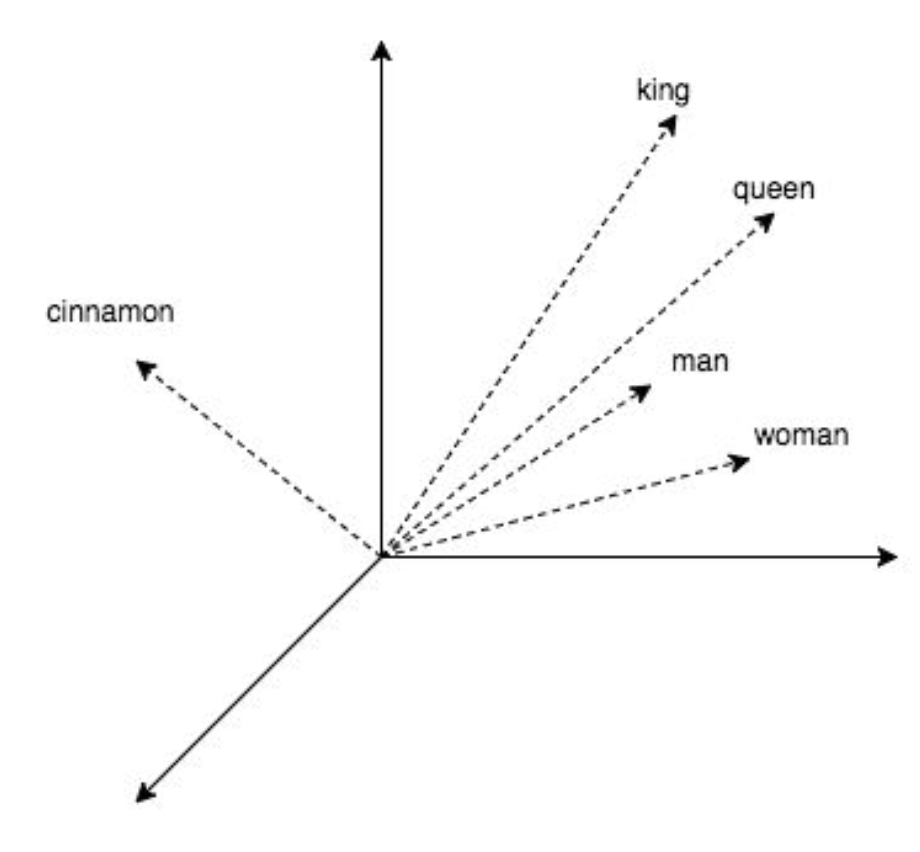

Для поиска похожих будем пользоваться [Facebook AI research Similarity Search](https://github.com/facebookresearch/faiss)

FAISS состоит из трех основных частей
1. Asymmetric distance computation (ADC)
2. Inverted file (IVF)
3. Product quantization (PQ)

#### 2.4.1 FAISS. ADC

1. Воспользуемся идеей корзинок и разделим наше пространство на кластеры с помощью K-Means
2. Для репрезентации корзины возьмем вектор центрального элемента
3. При запросе находим ближайший центр
4. Достаем элементы кластера через IVF (далее)

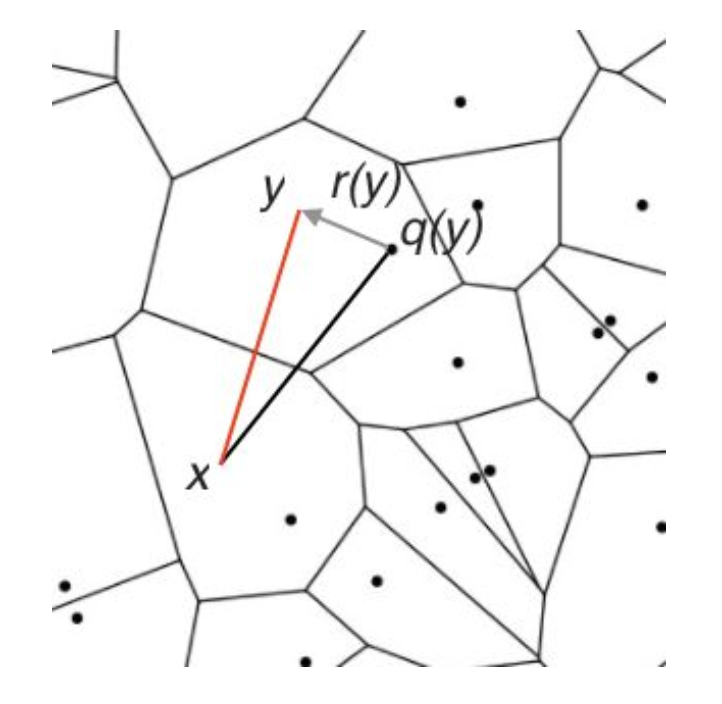

#### 2.4.1 FAISS. IVF

Для центров кластера просто храним список элементов в нем

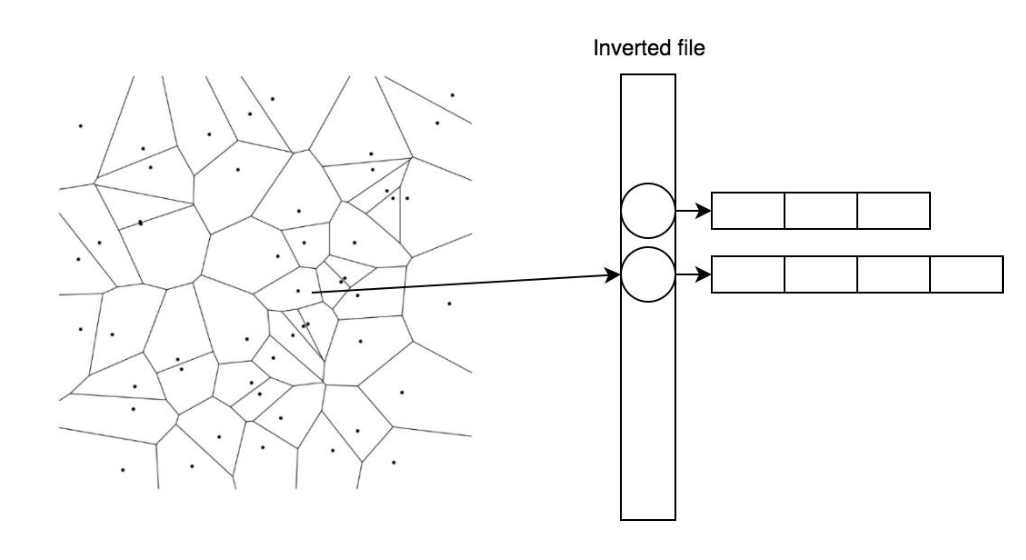

#### 2.4.2 FAISS. PQ

1. Вычитаем элементы центроида из вектора
2. Делим полученный вектор на корзинки
3. Каждую из частей кластеризуем и заменяем индексом центра

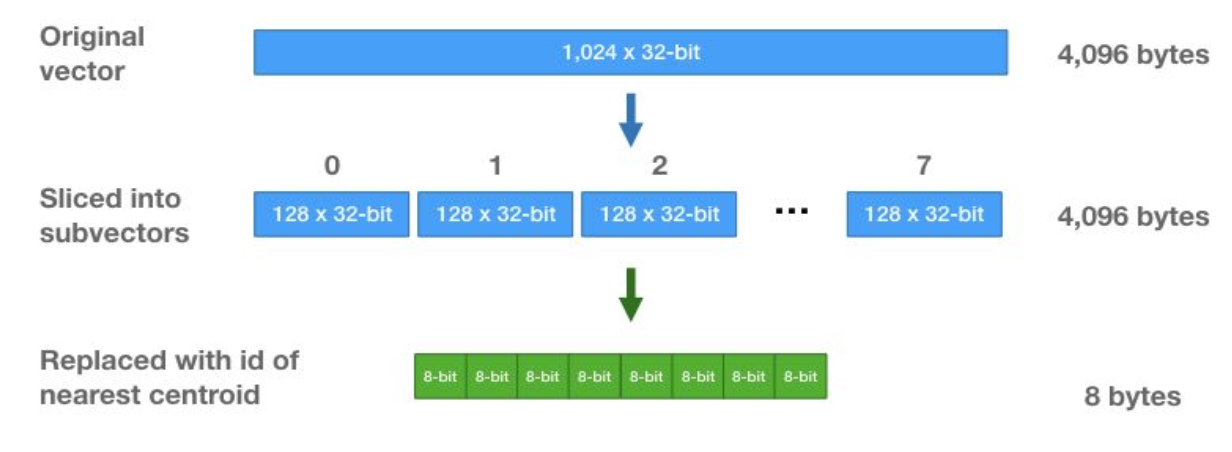

*Подробнее можно посмотреть [тут](https://mccormickml.com/2017/10/13/product-quantizer-tutorial-part-1/)*

Алгоритм:

1. При запросе находим несколько ближайших центров кластеров
2. Достаем элементы кластера через IVF
3. Остаток вектора от запроса до центра
кластера кодируется через PQ
4. Расстояние от запроса до элемента
определяется, как сумма расстояний от центров кластеров между всеми корзинками
5. Достаем ближайших

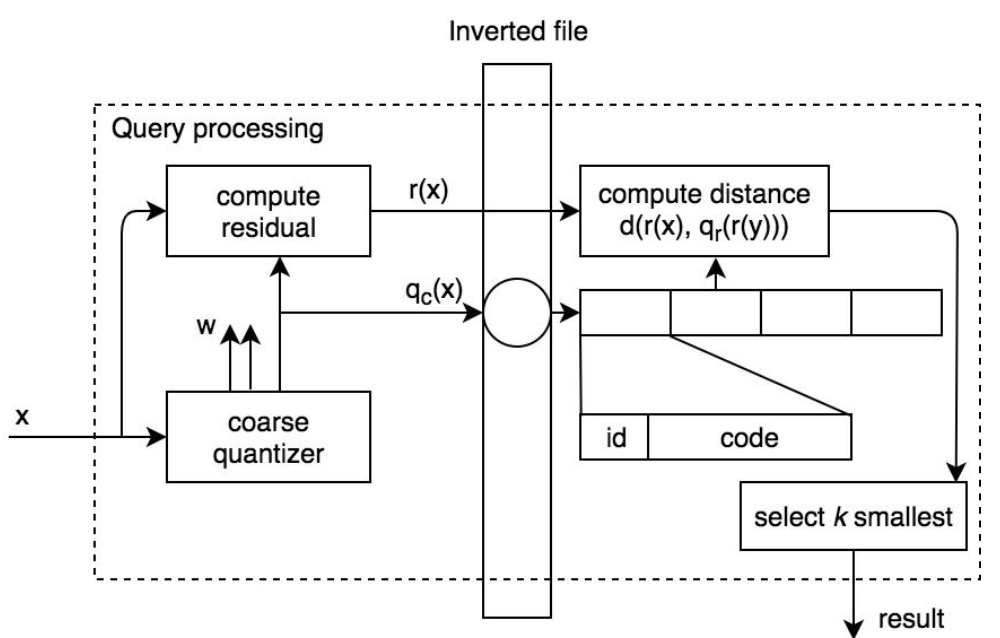

Два основных параметра, которыми мы рулим:

1. **кол-во центройдов**
    * Определяет на сколько частей мы бьем наше пространство
    * Если их мало, то будет долгий поиск, т.к. почти фулл скан нужно сделать
    * Чем больше центройдов, тем дольше строить индекс
2. **nprobes**
    * Кол-во проб (т.е. поисков по центройдам)
    * При =1 берем только самый ближайший, но тогда будет низкая точность :(
    * Линейно зависит время поиска

 Есть и другие алгоритмы поиска ближайших соседей, достойны упоминания: [Annoy](https://github.com/spotify/annoy), [HNSW](https://en.wikipedia.org/wiki/Hierarchical_navigable_small_world)

🤔 *Интересно, хоть кто-нибудь тыкает на ссылки, которые я прикладываю*


In [ ]:
pl_model.eval()
pl_model.to(DEVICE)

In [ ]:
def get_embeds(model, loader):
    embeddings = np.empty((1,512))
    labels = np.empty((1))
    for batch in tqdm.tqdm_notebook(loader):
        imgs = batch['image']
        label = batch['label']
        with torch.no_grad():
            preds = model(imgs.to(DEVICE))
        embeddings = np.concatenate([embeddings, preds.cpu().numpy()])
        labels = np.concatenate([labels, label.numpy()])
    return embeddings[1:].astype(np.float32), labels[1:]

In [ ]:
train_emb, train_labels = get_embeds(pl_model, train_loader)
val_emb, val_labels = get_embeds(pl_model, valid_loader)

In [ ]:
# Построение индекса
index = faiss.IndexFlatL2(512)
print(index.is_trained)

# Добавление векторов в индекс
index.add(train_emb)
print(index.ntotal)

# Хотим увидеть 4 ближайших соседа
k = 4

# Проверка корректности работы
D, I = index.search(train_emb[:5], k)

# Индексы 4-х ближайших соседей для первых 5 векторов обучающей выборки
print(I)

# Расстояния до 4-х ближайших соседей для первых 5 векторов обучающей выборки
print(D)

# Фактический поиск
D, I = index.search(val_emb, k)

# Соседи первых 5 запросов
print(I[:5])

# Соседи последних 5 запросов
print(I[-5:])



---



### 2.5 Оценка качества

In [ ]:
Distances, Indexes = index.search(val_emb, 1)

In [ ]:
print(f'Precision/Recall @ 1 : {np.sum((val_labels == train_labels[Indexes.flatten()]))/val_labels.shape[0]}')



---



## 3. GradCam

Ниже рассмотрим [библиотеку GradCam](https://github.com/jacobgil/pytorch-grad-cam) для интерпретации работы моделей компьютерного зрения


In [37]:
transform_to_show = torchvision.transforms.Compose([
                        torchvision.transforms.ToPILImage(),
                        torchvision.transforms.Resize(size=(224, 224)),
                        torchvision.transforms.ToTensor()])

def get_image_from_url(url):
    """A function that gets a URL of an image,
    and returns a numpy image and a preprocessed
    torch tensor ready to pass to the model """

    orig_im = np.array(Image.open(requests.get(url, stream=True).raw))
    rgb_im = np.array(transform_to_show(orig_im).permute(1,2,0))
    transformed_im = val_transforms(orig_im).unsqueeze(0).to(DEVICE)
    orig_im = cv2.resize(orig_im, (512, 512))

    return orig_im, rgb_im, transformed_im

In [38]:
car_img, car_img_float, car_tensor = get_image_from_url("https://1.bp.blogspot.com/-wxBCzsQLWN4/ThPsv_RkoGI/AAAAAAAAAKo/wWYCiXOYsKM/s1600/2011-Dodge-Challenger-SRT8-392-feature.jpg")
cloud_img, cloud_img_float, cloud_tensor = get_image_from_url("https://th.bing.com/th/id/OIP.CmONj_pGCXg9Hq9-OxTD9gHaEo?pid=ImgDet&rs=1")
car_concept_features = pl_model(car_tensor)[0, :]
cloud_concept_features = pl_model(cloud_tensor)[0, :]

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

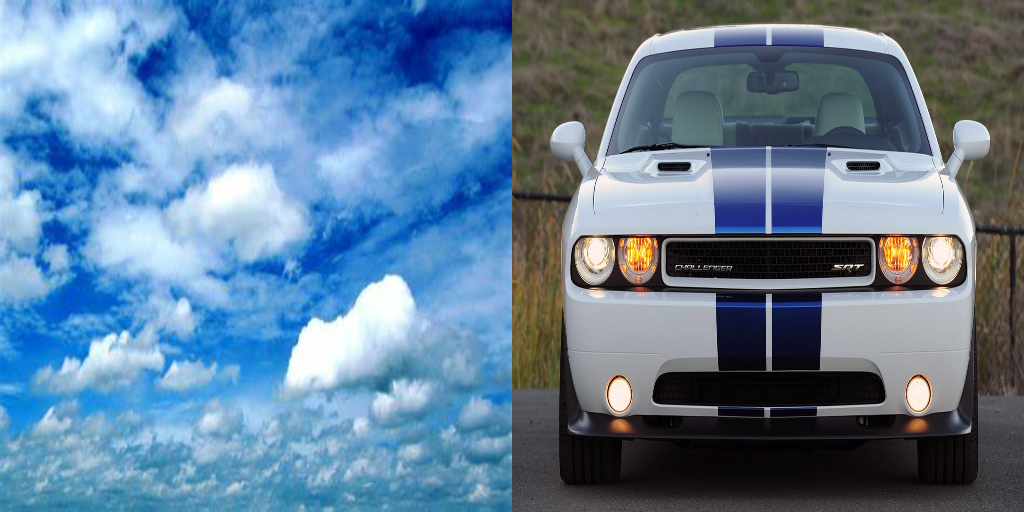

In [39]:
Image.fromarray(np.hstack((cloud_img, car_img)))

In [40]:
image, image_float, input_tensor = get_image_from_url("http://www.asilzeminmarket.com/uploaded/urunler/12/buyuk/481_1403104977_A_50jpg.jpg")
Image.fromarray(image)

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7ede641ed300>

In [ ]:
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features

    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(model_output, self.features)

In [ ]:
target_layers = [pl_model.model.layer4[-1]]
car_targets = [SimilarityToConceptTarget(car_concept_features)]
cloud_targets = [SimilarityToConceptTarget(cloud_concept_features)]

In [ ]:
# Where is the car in the image
with GradCAM(model=pl_model.model,
             target_layers=target_layers,
             use_cuda=False) as cam:
    car_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=car_targets)[0, :]
car_cam_image = show_cam_on_image(image_float, car_grayscale_cam, use_rgb=True)
Image.fromarray(car_cam_image)

In [ ]:
# Where is the cloud in the image
with GradCAM(model=pl_model.model,
             target_layers=target_layers,
             use_cuda=False) as cam:
    cloud_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=cloud_targets)[0, :]
cloud_cam_image = show_cam_on_image(image_float, cloud_grayscale_cam, use_rgb=True)
Image.fromarray(cloud_cam_image)

In [ ]:
class DifferenceFromConceptTarget:
    def __init__(self, features):
        self.features = features

    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return 1 - cos(model_output, self.features)

not_car_targets = [DifferenceFromConceptTarget(car_concept_features)]
not_cloud_targets = [DifferenceFromConceptTarget(cloud_concept_features)]

In [ ]:
# Where is the cloud not in the image?
with GradCAM(model=pl_model.model,
             target_layers=target_layers,
             use_cuda=False) as cam:
    not_cloud_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=not_cloud_targets)[0, :]
cam_image = show_cam_on_image(image_float, not_cloud_grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)

In [ ]:
# Where is the car not in the image?
with GradCAM(model=pl_model.model,
             target_layers=target_layers,
             use_cuda=False) as cam:
    not_car_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=not_car_targets)[0, :]
cam_image = show_cam_on_image(image_float, not_car_grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)



---



### Задание Metric Learning и GradCam (5 баллов)

1. Реализовать метрики: Precision@k, Recall@k, mAP
2. Добавить train - аугментации
3. Попробовать обучить другой backbone
4. Добавить triplet-loss (не забыть сэмплирование в батч)
5. Показать с помощью GradCam, где ошибается модель

In [42]:
from sklearn.metrics import precision_score, recall_score

def precision_at_k(y_true, y_pred, k=3):
    top_k_preds = torch.topk(y_pred, k, dim=1).indices
    correct = (top_k_preds == y_true.unsqueeze(1)).float()
    return correct.sum() / len(y_true)

def recall_at_k(y_true, y_pred, k=3):
    top_k_preds = torch.topk(y_pred, k, dim=1).indices
    correct = (top_k_preds == y_true.unsqueeze(1)).float()
    return correct.sum() / len(y_true)

def mean_average_precision(y_true, y_pred, k=5):
    avg_precision = []
    for i in range(len(y_true)):
        precision = []
        for j in range(k):
            precision.append(precision_score(y_true[i], y_pred[i, j]))
        avg_precision.append(np.mean(precision))
    return np.mean(avg_precision)


In [45]:
def mean_average_precision(y_true, y_pred, k=5):
    average_precisions = []
    for i in range(y_true.shape[0]):
        true_labels = y_true[i]
        pred_labels = y_pred[i]
        ap = 0
        for label in np.unique(true_labels):
            true_positive = np.sum(pred_labels == label)
            false_positive = np.sum(pred_labels != label)
            recall = true_positive / (true_positive + false_positive)
            precision = true_positive / (true_positive + false_positive)
            ap += (precision + recall) / 2
        average_precisions.append(ap)
    return np.mean(average_precisions)

In [44]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ColorJitter(p=0.5),
    A.GaussianBlur(p=0.3),
    A.Normalize(),
    A.CLAHE(p=0.5),
])

In [46]:
model = Unet("efficientnet-b0", encoder_weights="imagenet", classes=NUM_CLASSES, activation=None).cuda()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 90.9MB/s]


In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = F.pairwise_distance(anchor, positive, p=2)
        neg_dist = F.pairwise_distance(anchor, negative, p=2)
        loss = torch.clamp(pos_dist - neg_dist + self.margin, min=0.0)
        return loss.mean()


In [48]:
def train_triplet(model, train_loader, epochs=10, margin=1.0, lr=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    triplet_loss_fn = TripletLoss(margin=margin)

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, masks in tqdm(train_loader):
            anchor = images[0]
            positive = images[1]
            negative = images[2]
            anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()
            optimizer.zero_grad()
            anchor_out = model(anchor)
            positive_out = model(positive)
            negative_out = model(negative)

            loss = triplet_loss_fn(anchor_out, positive_out, negative_out)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Triplet Loss: {running_loss / len(train_loader)}")

In [49]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.activations = None

    def save_gradients(self, grad):
        self.gradients = grad

    def hook_layers(self):
        def hook_fn(module, input, output):
            self.activations = output
            output.register_hook(self.save_gradients)

        self.model.layer4[1].register_forward_hook(hook_fn)

    def generate_cam(self, input_image):
        self.hook_layers()
        output = self.model(input_image)
        gradients = self.gradients[0].cpu().data.numpy()
        activations = self.activations[0].cpu().data.numpy()

        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, weight in enumerate(weights):
            cam += weight * activations[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (input_image.shape[2], input_image.shape[3]))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)

        return cam

def show_gradcam(model, input_image):
    grad_cam = GradCAM(model)
    cam = grad_cam.generate_cam(input_image)

    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.show()




---



# Домашнее задание № 7

Выполните все задания в этом ноутбуке

+ Мягкий дедлайн: `14.03.25 23:59`
+ Жесткий дедлайн: `21.03.25 23:59` (половина баллов)


После жесткого дедлайна задание не принимается.

Результат обучения дообучения resnet34: Train Loss: 0.1766, Val Loss: 0.2205, mean IoU: 0.6578. В целом, достаточно неплохо предсказываются области.